**Resolucion anonima de compañere** Ultra completisima, una locura

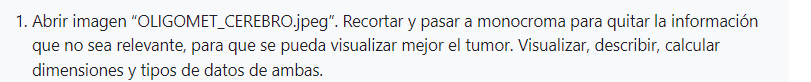



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage, datasets
import scipy.io

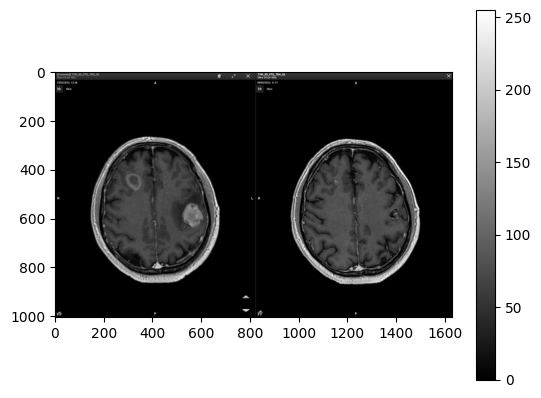

In [2]:
Cerebro=cv2.imread('OLIGOMET_CEREBRO.jpeg',0)  #leemos el archivo de imagen
# Cerebro=Cerebro[:,:,0] , SI: cv2.imread('OLIGOMET_CEREBRO.jpeg')
plt.imshow(Cerebro, cmap="gray")               #previsualizamos
plt.colorbar()
plt.show()


Recortamos:

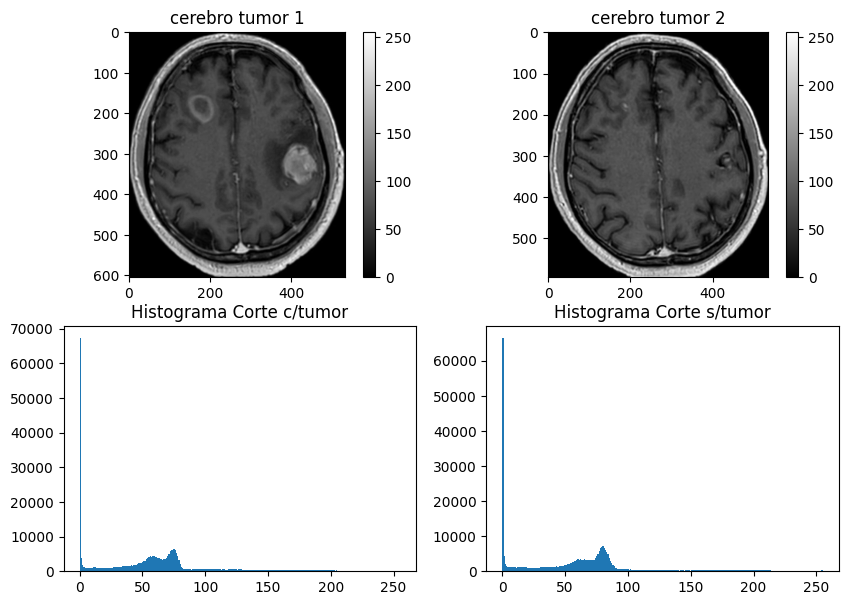

Cerebro_1: uint8 (605, 535)
Cerebro_2: uint8 (595, 535)


In [3]:
Cerebro_1=Cerebro[260:865,145:680]

Cerebro_2=Cerebro[270:865,965:1500]

plt.figure(figsize=(10,7))
plt.subplot(221)
plt.imshow(Cerebro_1, cmap="gray")
plt.title("cerebro tumor 1")
plt.colorbar()

plt.subplot(222)
plt.imshow(Cerebro_2, cmap="gray")
plt.title("cerebro tumor 2")
plt.colorbar()

plt.subplot(223)
plt.hist(np.ravel(Cerebro_1),bins=256)
plt.title('Histograma Corte c/tumor')

plt.subplot(224)
plt.hist(np.ravel(Cerebro_2),bins=256)
plt.title('Histograma Corte s/tumor')

plt.show()

print("Cerebro_1:", Cerebro_1.dtype, Cerebro_1.shape)
print("Cerebro_2:", Cerebro_2.dtype, Cerebro_2.shape)


**Descripcion:**

Estmaos viendo 2 imagnes que traia al iamgen original:

* Imagen izquierda: En esta se observa un corte a un nivel donde se hacen visibles 2 tumores uno en el hemisferio derecho en en una zona anterior del encefalo y otro en el hemisferio izquierdo en una zona mas bien medial.

* Imagne derecha: Esta imagen entiendo que fue tomada a un nivel mas profundo o mas superfical dodne no son visibles los cuerpos tumorales, a modo de que sirva como comapracion o control del anterior

Al comaprar los dos histogramas vemos que ambos presentan una inforamcion que no es relevante, la columna muy alta en los negros debido a los espacios oscuros donde no hay nada util. Se puede quitar para mejorar la visualizacion del histograma y de heco seria lo correcto, pero Seugn la consigna entendia que no hay que hacer zoom unicamente al tomor sino deja refrencia antaomica con toda la estructura cerebral.

**Ahora si al compara vemos que ambos tienn una distribucion muy similar, sin embargo en el que posee el corte al nivel de los tumores muestra un histograma mas cargado en los niveles de girses entre 50 y 60 considero que en esos niveles de grises estan represetnados los tumores y por eso esto no se observa asi en histograma del corte sin tumores.**

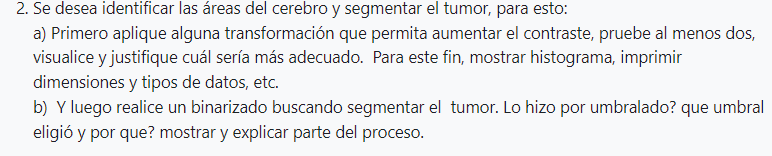

El contraste depende de 2 factores:

* Del rango dinamico
* Del nivel de uniformidad que poseen los grises de la imagen.

Si hubiesemos visto la tranfomacion de equializado de histograma, al aplicaria ya que al uniformizar la distribucion de grises de la imagen, habria un cambio bien notorio de un nivel a otro en la iamgen.

Como no vimos esta tranformacion la otra que se podria usar es la logaritmica, con el objetivo no de achicar el rango que suele ser su app mas comun, sino de aumentarlo.

la otra tranformacion que voy a aplicar (ya que pide 2) es la potencial gama, si bien esta tranformacion no modifica los valores extremos => no toca el rango dinamico de la imagen, si elijo un valor de gama menor que 1 puedo aclara un poco la iamgen intentando que se destaquen mas algunos detalles. Sin embargo esto no estaria mejorando el contraste como tal ya que al aplicarle la misma tranforamcion a cada pixel la distribucion de gireses sera la misma, solo que desplazará el hisograma  mas a la derecha.





Definimso la tranformacion Gama:

In [4]:
def imadjust(img, In=(0,1.0), Out=(0,1.0), gamma=1.0):
    "J = low_out +(high_out - low_out).* ((I - low_in)/(high_in - low_in)).^ gamma"
    low_in,high_in = In
    low_out, high_out = Out

    low_in *= 255.0
    high_in *= 255.0

    low_out *= 255.0
    high_out *= 255.0

    k = (high_out - low_out) / (high_in - low_in)
         # Gamma transformation table
    table = np.array([((i / 255.0) ** gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    h,w = img.shape[:2]
    imgOut = np.zeros((h,w), np.uint8)

    for r in range(h):
        for c in range(w):
            if img[r,c] <= low_in:
                imgOut[r,c] = low_out
            elif img[r,c] > high_in:
                imgOut[r,c] = high_out
            else:
                res = int(k*(img[r,c]-low_in) + low_out)
                imgOut[r,c] = table[res]#Check table

    return imgOut

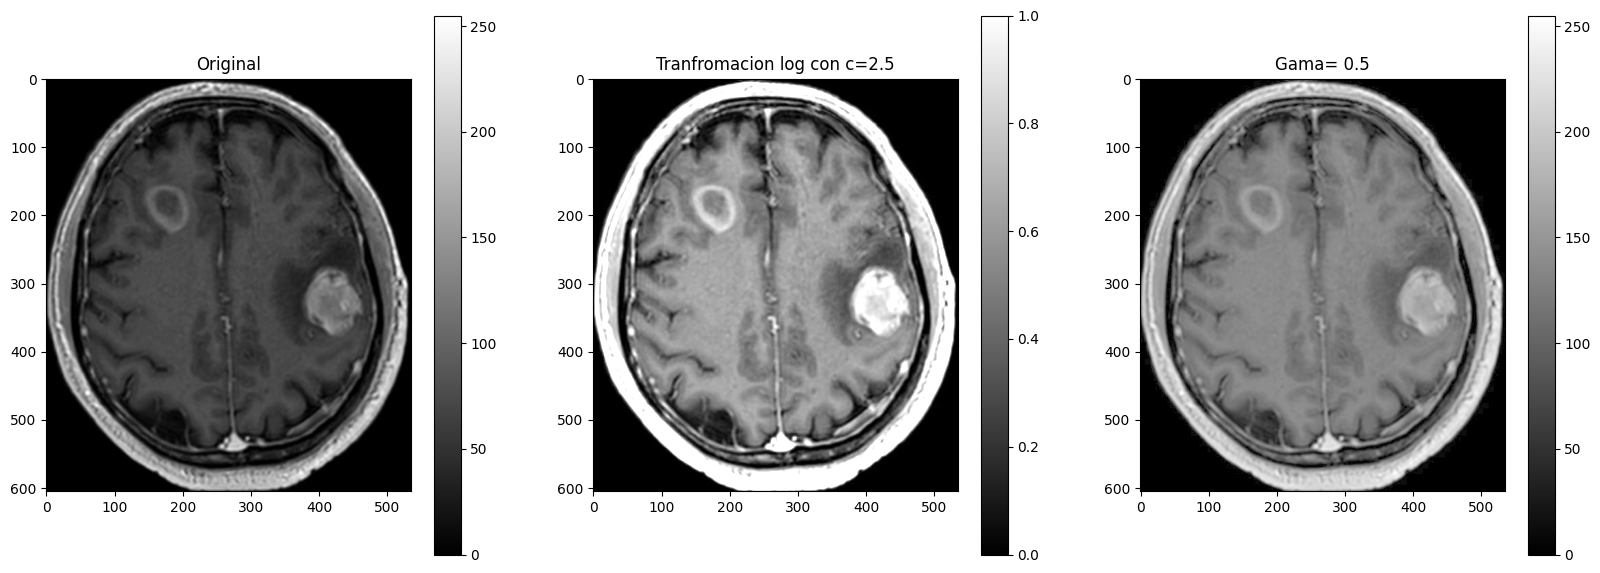

In [5]:
#Transformacion logaritmic
Cerebro_1f=Cerebro_1/np.amax(Cerebro_1)
c=2.5
Cerebro_1_Log= c* np.log(1 + abs(Cerebro_1f))           #preferencia mia trabajar con float pero se puede uint8

#Tranformacion gamma:
gamma=0.5
Cerebro_1_gamma=imadjust(Cerebro_1,(0,1),(0,1), gamma)   #recordar que se le introduce Uint8 y la funcion la pasa a float

plt.figure(figsize=(20,7))
plt.subplot(131)
plt.imshow(Cerebro_1,cmap="gray")
plt.title("Original")
plt.colorbar()

plt.subplot(132)
plt.imshow(Cerebro_1_Log, cmap="gray", vmin=0, vmax=1)
plt.title("Tranfromacion log con c=" +str(c))
plt.colorbar()

plt.subplot(133)
plt.imshow(Cerebro_1_gamma, cmap="gray")
plt.title("Gama= " +str(gamma))
plt.colorbar()
plt.show()

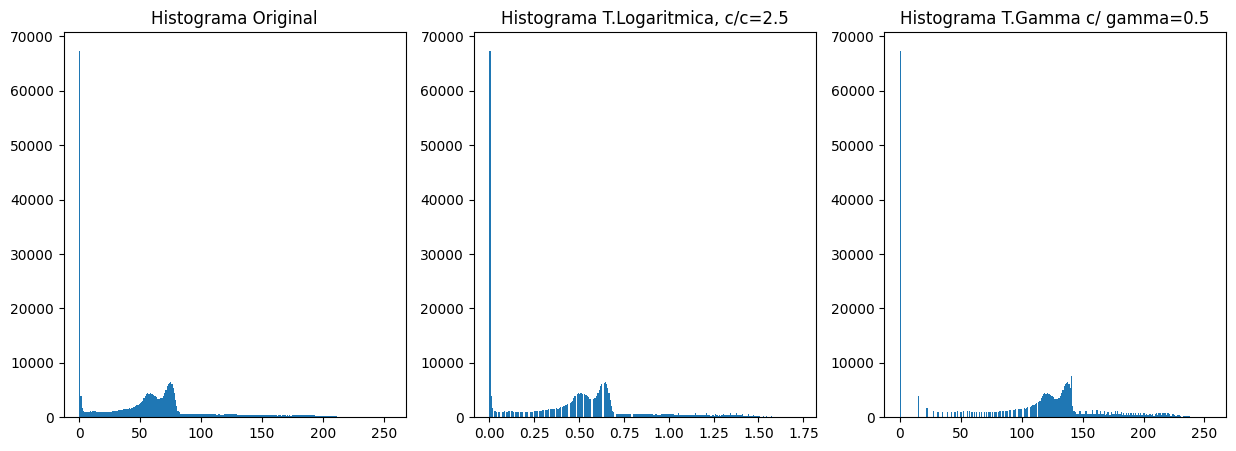

Orignal: uint8 minimo: 0 maximo: 255
Orignal_float: float64 minimo: 0.0 maximo: 1.0
Tranformacion log: float64 minimo: 0.0 maximo: 1.7328679513998633
Tranformacion Gamma: uint8 minimo: 0 maximo: 255


In [6]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(np.ravel(Cerebro_1),bins=256)  #ravel:desarma la matiz y genera un vector con la distribucion de intensidades
plt.title("Histograma Original")

plt.subplot(132)
plt.hist(np.ravel(Cerebro_1_Log), bins=256)
plt.title("Histograma T.Logaritmica, c/c=" + str(c))

plt.subplot(133)
plt.hist(np.ravel(Cerebro_1_gamma), bins=256)
plt.title("Histograma T.Gamma c/ gamma=" +str(gamma))
plt.show()


print("Orignal:",Cerebro_1.dtype,"minimo:",np.amin(Cerebro_1),"maximo:",np.amax(Cerebro_1) )
print("Orignal_float:",Cerebro_1f.dtype,"minimo:",np.amin(Cerebro_1f),"maximo:",np.amax(Cerebro_1f) )
print("Tranformacion log:",Cerebro_1_Log.dtype,"minimo:",np.amin(Cerebro_1_Log),"maximo:",np.amax(Cerebro_1_Log) )
print("Tranformacion Gamma:",Cerebro_1_gamma.dtype,"minimo:",np.amin(Cerebro_1_gamma),"maximo:",np.amax(Cerebro_1_gamma) )



### **Analisis de los resutlados:**


* Usando tranformacion logaritmica: Al selecciona un valor de c=2.5 hemos conseguido ampliar el rango dinamico de [0,1] a [0,1.73] luego como estamos imprimiendo las imagenes consdierando Vmin=0 y Vmax=1 esto implica que aquellos valores que queden fuera del rango >1 tendran un aspecto saturado, por lo que elgiendo adecuadamente c eh logrado resaltar mas las estructuras del cerebro, podemos decir que aumento el contraste ya que son claras las diferencias de un nivel de gris al otro y los tumores se ven con mayor intensidad respecto del tejido cirundante.

* Usando tranforamcion gamma, al aplicar un valor de gamma = 0,5 < 1 hemos aclarado la iamgen, el histograma desplazado hacia la derecha (girises mas claros) confirma esto. No hemos aumentado el constraste, la distribucion de grises siguie siendo la misma y el rango dinamico no se modificó. Si la idea es resaltar regiones cerebrales y contrastar mejor los tumores respecto de su tejido cirudndante ESTA no es una tranformacion adecuada para dicho fin.


**Conclución el resutlado obtendio al combinar la tranformación logaritmica con c=2.5 e imprimir la iamgen dentro del rango original vmin=0 y vmax=1 podemos decir que aumentó el contraste ya que el pasó de un nivel de gris a otro está mas resaltado.**




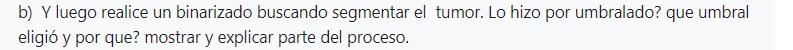

### **Paso 1) Determinacion del umbral, analisis de los niveles de gris en el area de interes**

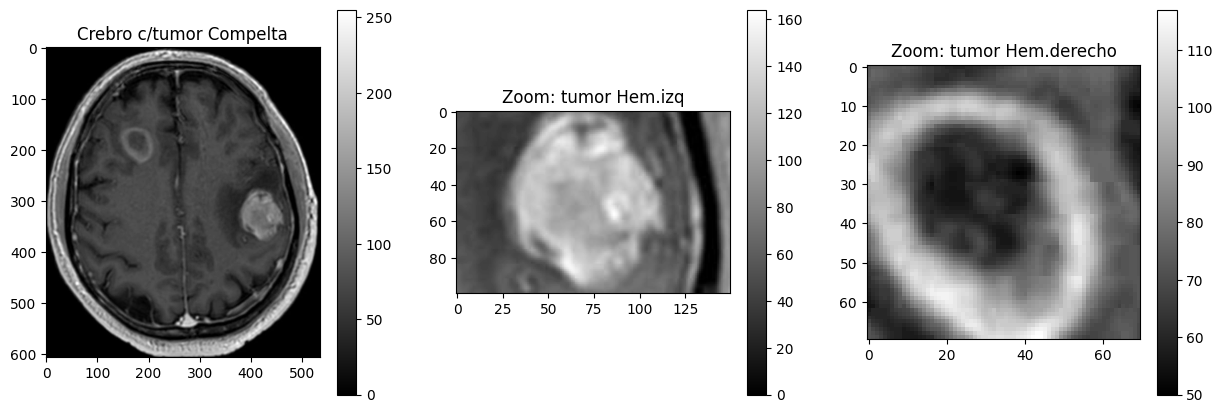

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(Cerebro_1, cmap="gray")
plt.title("Crebro c/tumor Compelta")
plt.colorbar()

plt.subplot(132)
plt.imshow(Cerebro_1[280:380,350:500], cmap="gray")
plt.title("Zoom: tumor Hem.izq")
plt.colorbar()

plt.subplot(133)
plt.imshow(Cerebro_1[150:220,150:220], cmap="gray")
plt.title("Zoom: tumor Hem.derecho")
plt.colorbar()

plt.show()



### **Rango de umbrales propuestos**
* Tumor Hemi.izqu grises: 100-160
* Tumor Hemi.dercho grises: 100-115

**Luego un umbral de 100 seria correcto para que cumpla con ambos, apartir de este valor podemos probar un poco menos o un poco mas.**



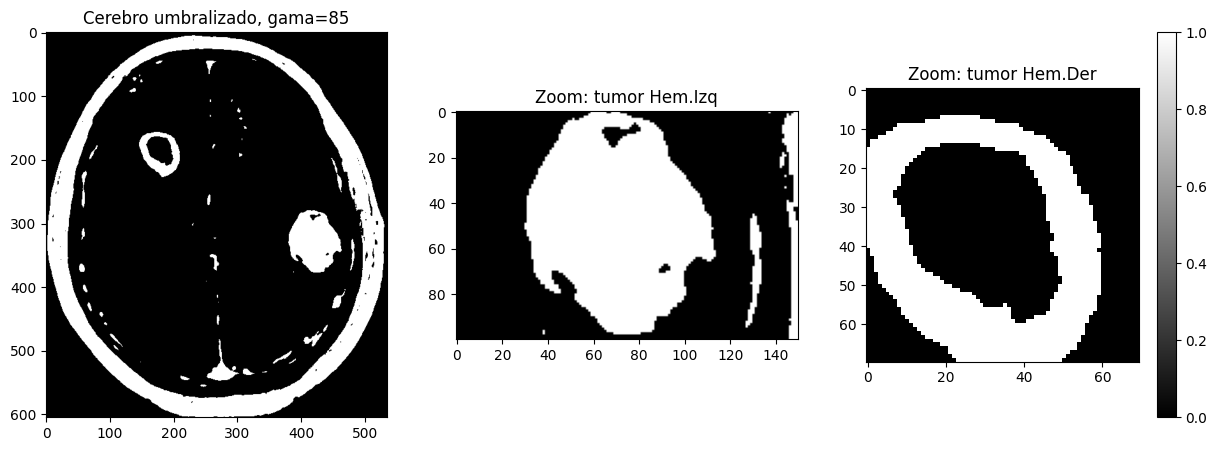

In [8]:
#METODO DE BINARIZADO: UMBRALIZADO. (Trabajo con imagen uint 8)
umbral=85
umbral1, Cerebro_1_umb= cv2.threshold(Cerebro_1,umbral,1,cv2.THRESH_BINARY)   #ya te devuevle en float64
Neumonia_izq_umb=imadjust(Cerebro_1_umb,(0,1),(1,0), 1)

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(Cerebro_1_umb, cmap="gray")
plt.title("Cerebro umbralizado, gama=" +str(umbral))

plt.subplot(132)
plt.imshow(Cerebro_1_umb[280:380,350:500], cmap="gray")
plt.title("Zoom: tumor Hem.Izq")

plt.subplot(133)
plt.imshow(Cerebro_1_umb[150:220,150:220], cmap="gray")
plt.title("Zoom: tumor Hem.Der")
plt.colorbar()


plt.show()







**Seleccion del umbral:**

* Primero se hizo un zoom al area de los tumores y se determinaron un rango aprixiumado de sus niveles de grieses
* Probamos con el valor minimo 100 para que cumpla con los rangos de ambas estructuras
*Apartir de este valor se ajusta levemetne hata que se consigue un resultado optimo.

*Nota: tambien se podrian haber vizualidado los histogramas de los 2 zooms y asi determinar un rango de grises mas exacto para ambos tumores*.

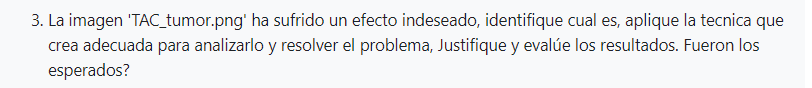

### **Paso1: visualizacion de la imagen defectuosa**

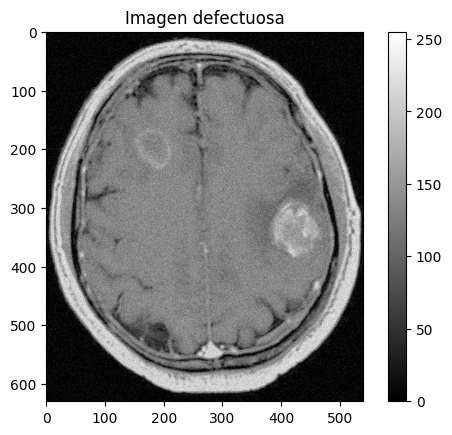

In [9]:
TAC_tumor=cv2.imread("TAC_tumor.png",0)
#visualizamos:
plt.imshow(TAC_tumor, cmap="gray")
plt.title("Imagen defectuosa")
plt.colorbar()
plt.show()


### **Paso 2: ¿Es ruido o distorcion?**

**Problema: Obsevamos que la imagen a sufrido la adicion de RUIDO en algun punto de la cadena de procesos hasta que llegó a nuestras manos.**

**Debemos determinar la naturaleza de este ruido, no su causa sino el tipo:**
* Sal y pimienta
* Ruido gaussiano


### **Paso 3: Determinar el tipo de Ruido:**

* Analizis del histograma de una regnion homogenea de la imagen

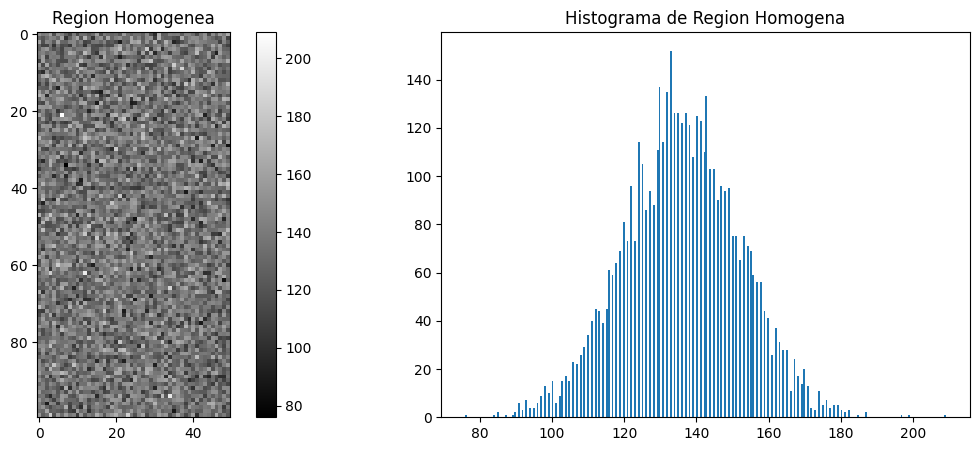

In [10]:
#visualizamos:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(TAC_tumor[280:380,180:230], cmap="gray")
plt.title("Region Homogenea")
plt.colorbar()

plt.subplot(122)
plt.hist(np.ravel(TAC_tumor[280:380,180:230]),bins=256)
plt.title("Histograma de Region Homogena")
plt.show()




## **Análisis:**

El histograma muestra claramente una distribucion de niveles de girses que siguen a una distribucion de campana Gaussiana, es decir existe un valor central (en torno a 140) y hay una disperción alrededor de este valor central que represetna el ruido que se adicionó a la zona que deberia tener una distribucion homogenea.

Este tipo de distribucion es típica del ruido gaussiano que tiene un tratamiento especifico, **El filtrado o promediado Gaussiano, (filtro lineal)**

## **Filtrado Lineal: Suavizado Gaussiano**

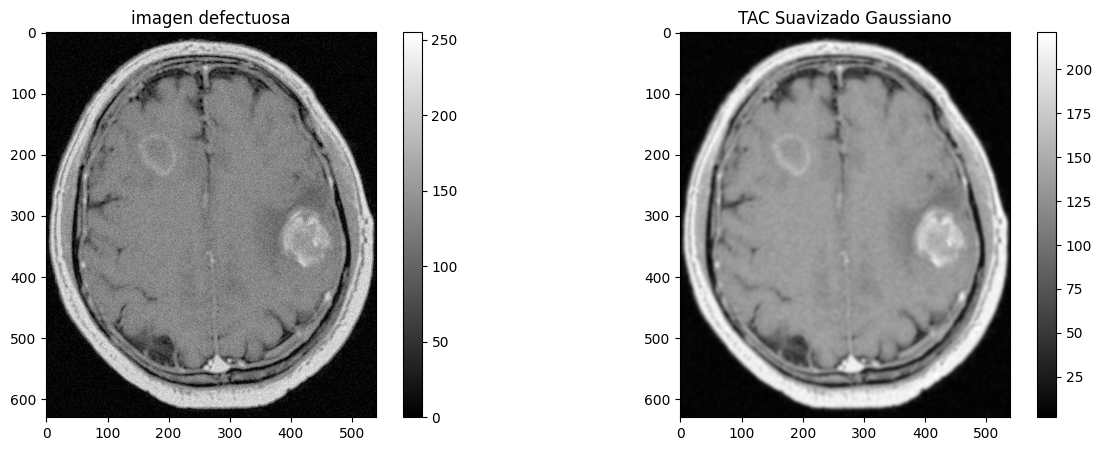

In [11]:
TAC_R=TAC_tumor.copy()    #generamos una copia (buena practica)
n=11
TAC_R=cv2.GaussianBlur(TAC_R,(n,n),2,2,0)  #cv2.GaussianBlur(ima_defct,(dimKernel),SigmX,SigmY,0)

#Graficamos las 2 para comparar:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(TAC_tumor, cmap="gray")
plt.title("imagen defectuosa")
plt.colorbar()

plt.subplot(122)
plt.imshow(TAC_R,cmap="gray")
plt.title("TAC Suavizado Gaussiano")
plt.colorbar()
plt.show()

### **Comparacion del nuevo histograma en la zona Homogenea**

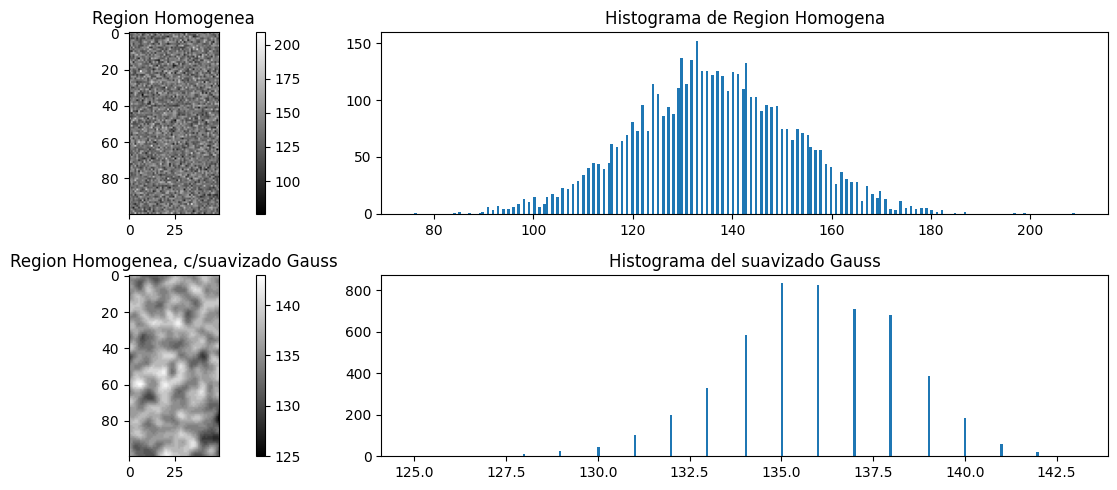

In [12]:
#visualizamos:
plt.figure(figsize=(15,5))
plt.subplot(221)
plt.imshow(TAC_tumor[280:380,180:230], cmap="gray")
plt.title("Region Homogenea")
plt.colorbar()

plt.subplot(222)
plt.hist(np.ravel(TAC_tumor[280:380,180:230]),bins=256)
plt.title("Histograma de Region Homogena")

plt.subplot(223)
plt.imshow(TAC_R[280:380,180:230], cmap="gray")
plt.title("Region Homogenea, c/suavizado Gauss")
plt.colorbar()

plt.subplot(224)
plt.hist(np.ravel(TAC_R[280:380,180:230]),bins=256)
plt.title("Histograma del suavizado Gauss")

plt.tight_layout()
plt.show()





### **Analisis de resultados y concluciones:**

## **Al comaprar las imagenes:**
Al comaprar la imagen defectuosa inicial con la imagen con el filtro de suavizado Gaussiano aplicado notamos a priori una gran mejoria, si bien no se ha logrado eliminar por completo el ruido si se lo ha limpiado bastante, la imagen se nota a su vez mas clara ya que el rudio se distribuia alrededor de un valor central, habiamos dicho 140. Ese valor central aproximado es el valor que deberia de tener la zona uniforme, por lo que el suaviado lo que permitió es filtrar aquellos pixeles que se aparataban mucho de este valor.

## **Al comparar los histogramas:**
Se observa como al distrribucion del ruido sigue siendo guassiana pero ahora la dispercioó alrededor del valor central es mucho menor, es decir se han suprimido los cambios bruscos de intensidad (frecuencias altas) Ahora tenemso una mayor cantidad de pixeles en torno al velor central que antes, eso explica el efcecto de aclarado que tiene la imagen resutlado.

En banse a ambas comparaciones puedo concluir que la elección de esta herramienta de filtrado gaussiana fue satisfactoria, el resutlado es mejor que la imagen primaria.


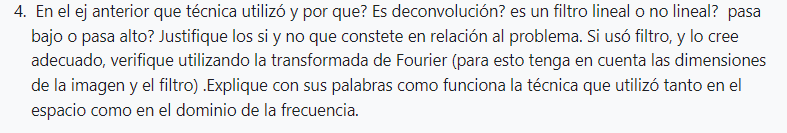

* ¿Técnica de mejoramiento de imagen utilizada?

**Suavizado Gaussiano**, ya que el tipo de ruido que poseia la iamgen al visualizarse el histograma de una región homegenea mostraba una distribuicion que seguia una campana gausiana, donde el rudio se adicionaba en torno a un valor central propio de dicha region del cerebro. (el valor central era informacion lo que se sumaba alrededor de este era ruido.) Por lo tanto la logica de aplicar un filtrado gaussiano es utilizar un kernel que promedie las intensideades de los pixeles alrededor de este valor central que representa informacion, la dureza del promedidado lo da las dimensiones del kernel como las desvaciones estandares consideradas, se tuvo cuidado de que estas elecciones no comprometan demasiado la nitidez de la iamgen.

* ¿Es deconvolucion?

No, la tecnica de deconvolucion se aplica para devovler a la imagen original apartir de la distrocionada cuando podemos determinar el kernel que representa la distorcion que sufró la imagen. **El rudio es un evento aleatorio no es posible modelizarlo solo determinar su tipo y aplicar soluciones parciales**

* ¿Es un filtro lineal o No lineal?

**El suavizado gaussiano es un filtrado lineal**, es decir que el proceso de filtrado se realiza por una combinacion lineal (sumas de productos) entre las intensidades de los pixeles de la iamgen y sus pesos y los pesos del kernel utilizado.

* ¿Pasa bajo o pasa alto?

El suaviazado gaussiano es un **filtrado lineal tipo pasa bajo**, donde se suprimen los cambios bruscos de intensidad que introduce el ruido en la iamgen, dejando pasar o manteniendo aquellos valores que esten mas proximos al valor central.










**Si usó filtro y lo cree adecuado, verifique utilizadno la tranformada de Fourier (para esto tenga en cuenta las dimensiones de la imagen y el filtro). Explique con sus palabras como funciona la tecnica que utilizó tanto en el espacio como en el dominio de la frecuencia.**

In [13]:
#Función para generar un kernel Gausiano 2D
def GaussianKernel2D(nfil, ncol, sigmaf, sigmac):
    return(np.dot(cv2.getGaussianKernel(nfil, sigmaf), np.transpose(cv2.getGaussianKernel(ncol, sigmac))))

[[0.    0.    0.001 0.001 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
 [0.    0.001 0.002 0.003 0.005 0.005 0.005 0.003 0.002 0.001 0.   ]
 [0.001 0.002 0.004 0.008 0.012 0.013 0.012 0.008 0.004 0.002 0.001]
 [0.001 0.003 0.008 0.015 0.022 0.024 0.022 0.015 0.008 0.003 0.001]
 [0.002 0.005 0.012 0.022 0.031 0.035 0.031 0.022 0.012 0.005 0.002]
 [0.002 0.005 0.013 0.024 0.035 0.04  0.035 0.024 0.013 0.005 0.002]
 [0.002 0.005 0.012 0.022 0.031 0.035 0.031 0.022 0.012 0.005 0.002]
 [0.001 0.003 0.008 0.015 0.022 0.024 0.022 0.015 0.008 0.003 0.001]
 [0.001 0.002 0.004 0.008 0.012 0.013 0.012 0.008 0.004 0.002 0.001]
 [0.    0.001 0.002 0.003 0.005 0.005 0.005 0.003 0.002 0.001 0.   ]
 [0.    0.    0.001 0.001 0.002 0.002 0.002 0.001 0.001 0.    0.   ]]
Notar que la suma de los coeficientes es igual a: 1.0000000000000004


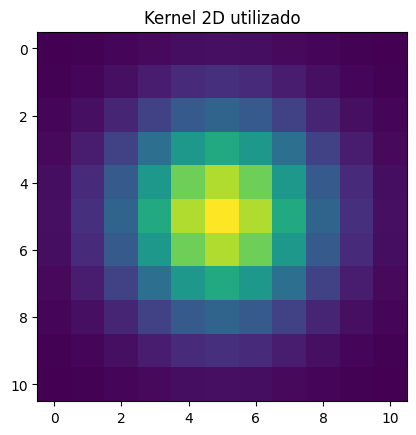

In [14]:
nfil=11
ncol=11
sigmaf=2
sigmac=2
kernel_gauss2D = GaussianKernel2D(nfil, ncol, sigmaf, sigmac) #función antes definida


print(np.round(kernel_gauss2D, decimals=3))
print('Notar que la suma de los coeficientes es igual a:',np.sum(kernel_gauss2D))
plt.imshow(kernel_gauss2D)
plt.title("Kernel 2D utilizado")
plt.show()

## **Verificacion dde que el suavizado gaussiano es un filtado, y un filtrado pasa bajos**

In [15]:
TF_TAC=np.fft.fft2(TAC_tumor)

s_0= TF_TAC.shape[0] #aseguramos las mismas dimensiones de ambas tranformadas P/ prodcuto lugar a lugar
s_1= TF_TAC.shape[1]

TF_k=np.fft.fft2(kernel_gauss2D,(s_0,s_1)) #Tranformada del kernel Guassiano con dimensiones de la imagen

#Filtrado en frecuencia (prodcuto lugar a lugar ):
TF_TAC_R=TF_TAC*TF_k
#volvemos al dom espacial para ver el resultado
TAC_R2= np.fft.ifft2(TF_TAC_R)

print("El tamaño de TF_TAC es ", TF_TAC.shape)
print("El tamaño de TF_k", TF_k.shape)
print("El tamaño de TF_TAC", TF_TAC.shape)

El tamaño de TF_TAC es  (630, 540)
El tamaño de TF_k (630, 540)
El tamaño de TF_TAC (630, 540)


## **Visión en frecuencia del filtrado:**

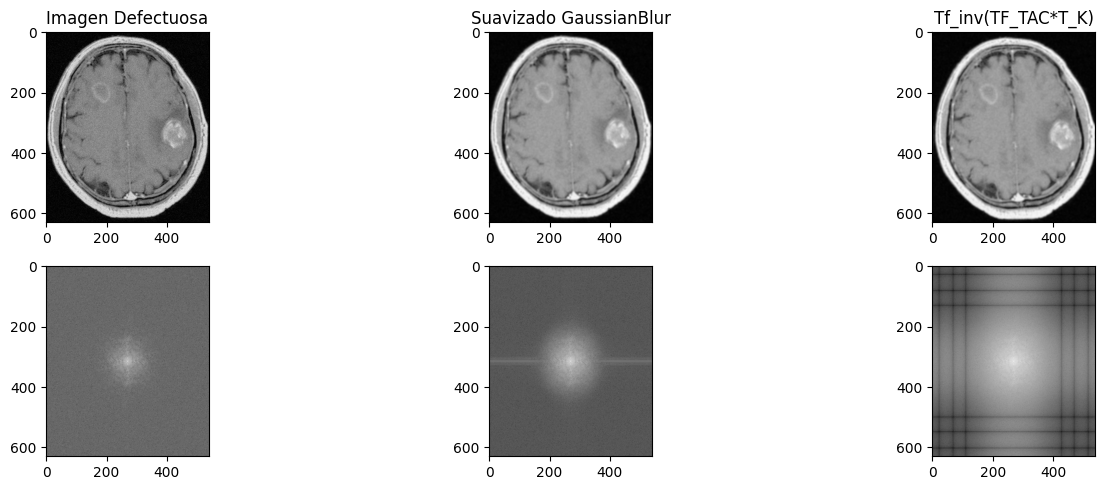

In [16]:

plt.figure(figsize=(15,5))

plt.subplot(231)
plt.imshow(TAC_tumor, cmap="gray")            #imagen con ruido
plt.title('Imagen Defectuosa')

plt.subplot(232)
plt.imshow(TAC_R, cmap="gray")
plt.title("Suavizado GaussianBlur")              #imagen con GaussianBlur

plt.subplot(233)
plt.imshow(abs(TAC_R2), cmap="gray")          #imagen filtada en frecuencia
plt.title("Tf_inv(TF_TAC*T_K)")

#tranformadas:
plt.subplot(234)
plt.imshow(20*np.log(abs(np.fft.fftshift(TF_TAC))), cmap = 'gray')

plt.subplot(235)
plt.imshow(20*np.log(abs(np.fft.fftshift(np.fft.fft2(TAC_R)))), cmap = 'gray')

plt.subplot(236)
plt.imshow(20*np.log(abs(np.fft.fftshift(TF_TAC_R))), cmap = 'gray')

plt.tight_layout()
plt.show()
